In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import camb
from camb import model, initialpower
import pandas as pd
import re

In [3]:
omega_nu = np.array([0.0006356, 0.002, 0.006356])
omega_index = 1 # while we debug, we confine our attention to just one value

In [5]:
# Keep in mind that this is NOT the same file as the original "cosmology_Aletheia.dat"
# that Ariel gave us! If you use the unaltered version, you will get a segfault
cosm = pd.read_csv("../shared/data/cosmologies.dat", sep='\s+')

# The following code is somewhat hard;
# I'm not sure how better to do it.
redshift_column = re.compile("z.+")

In [6]:
def parse_redshifts(model_num):
    """
    Return the list of amplitude-equalized redshifts
    given for a particular model in the Aletheia dat file.
    
    This function is intended to return the redshifts
    in order from high (old) to low (recent),
    which is the order that CAMB will impose
    if not already used.
    """
    z = []
    model = cosm.loc[model_num]
    
    for column in cosm.columns:
        if redshift_column.match(column):
            z.append(model[column])
            
    # No need to sort these because they should already
    # be in descending order.
    return np.array(z)

In [7]:
def kzps(mlc, omnuh2_in, massive_neutrinos=False, sigma12_in=1, zs = [0]):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mlc : "MassLess Cosmology"
        a dictionary of values
        for CAMBparams fields
    @param omnuh2_in : neutrino physical mass density
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the desired sigma12 of the model
    @massive_neutrinos : if this is True,
        the value in omnuh2_in is used to set omnuh2.
        If this is False,
        the value in omnuh2_in is simply added to omch2.
    """ 
    pars = camb.CAMBparams()
    omch2_in = mlc["omch2"]
    mnu_in = 0
    
    # nnu_in = 3.046
    nnu_massive = 0
    if massive_neutrinos:
        # This is a horrible workaround, and I would like to get rid of it ASAP
        # The following line destroys dependence on TCMB and neutrino_hierarchy, possibly more
        
        # What should replace default_nnu in the following expression?
        # Even if we're changing N_massive to 1, N_total_eff = 3.046 nonetheless, right?
        mnu_in = omnuh2_in * camb.constants.neutrino_mass_fac / \
            (camb.constants.default_nnu / 3.0) ** 0.75 
        # mnu_in = omnuh2_in * camb.constants.neutrino_mass_fac / (2.046 / 3) ** 0.75 
        
        omch2_in -= omnuh2_in
        nnu_massive = 1
    pars.set_cosmology(
        H0=mlc["h"] * 100,
        ombh2=mlc["ombh2"],
        omch2=omch2_in,
        omk=mlc["OmK"],
        mnu=mnu_in,
        num_massive_neutrinos=nnu_massive#,
        #neutrino_hierarchy="normal"
    )
    pars.InitPower.set_params(As=mlc["A_s"], ns=mlc["n_s"])
    
    #pars.DarkEnergy = camb.dark_energy.DarkEnergyPPF(w=mlc["w0"], wa=float(mlc["wa"]))
    pars.set_dark_energy(w=mlc["w0"], wa=float(mlc["wa"]), dark_energy_model='ppf')
    
    # The following bogus line can expose whether the simulation is paying attention to DE
    # (for some reason, the pair (-100, -100) did not look strange at all!) 
    # pars.set_dark_energy(w=-0, wa=0, dark_energy_model='ppf') 
    
    # To change the the extent of the k-axis,
    # change the following line as well as the "get_matter_power_spectrum" call
    pars.set_matter_power(redshifts=zs, kmax=10.0,
        nonlinear=False)#, accurate_massive_neutrino_transfers=True)
    #pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)

    k, z, p = results.get_matter_power_spectrum(
        minkh=1e-4, maxkh=10.0, npoints = 10000,
        var1=8, var2=8
    )
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    
    # The following line is helpful when debugging the mnu \ omnuh2 shenanigans
    #print("my nu density:", pars.omnuh2)
    
    return k, z, p, sigma12

In [8]:
# Let us begin our demonstration by considering only the
# middle of the
# given neutrino mass physical densities, omega_nu[omega_index]
k_massless_list = []
z_massless_list = []
p_massless_list = []
s12_massless_list = []

for index, row in cosm.iterrows():
    if index > 7:
        continue # Don't know how to handle the last one yet
    
    z_in = parse_redshifts(index)
    
    k, z, p, s12 = kzps(row, omega_nu[omega_index], massive_neutrinos=False,
                       zs=z_in)
    k_massless_list.append(k)
    z_massless_list.append(z)
    p_massless_list.append(p)
    s12_massless_list.append(s12)

In [9]:
colors = ["gray", "blue", "cyan", "black", "green", "purple", "yellow", "brown"]
# Argh! We have duplicates!!
#styles = ["solid", "dotted", "dashed", "dashdot", "solid", "dotted", "dashed", "dashdot"]
styles = ["solid"] * 8

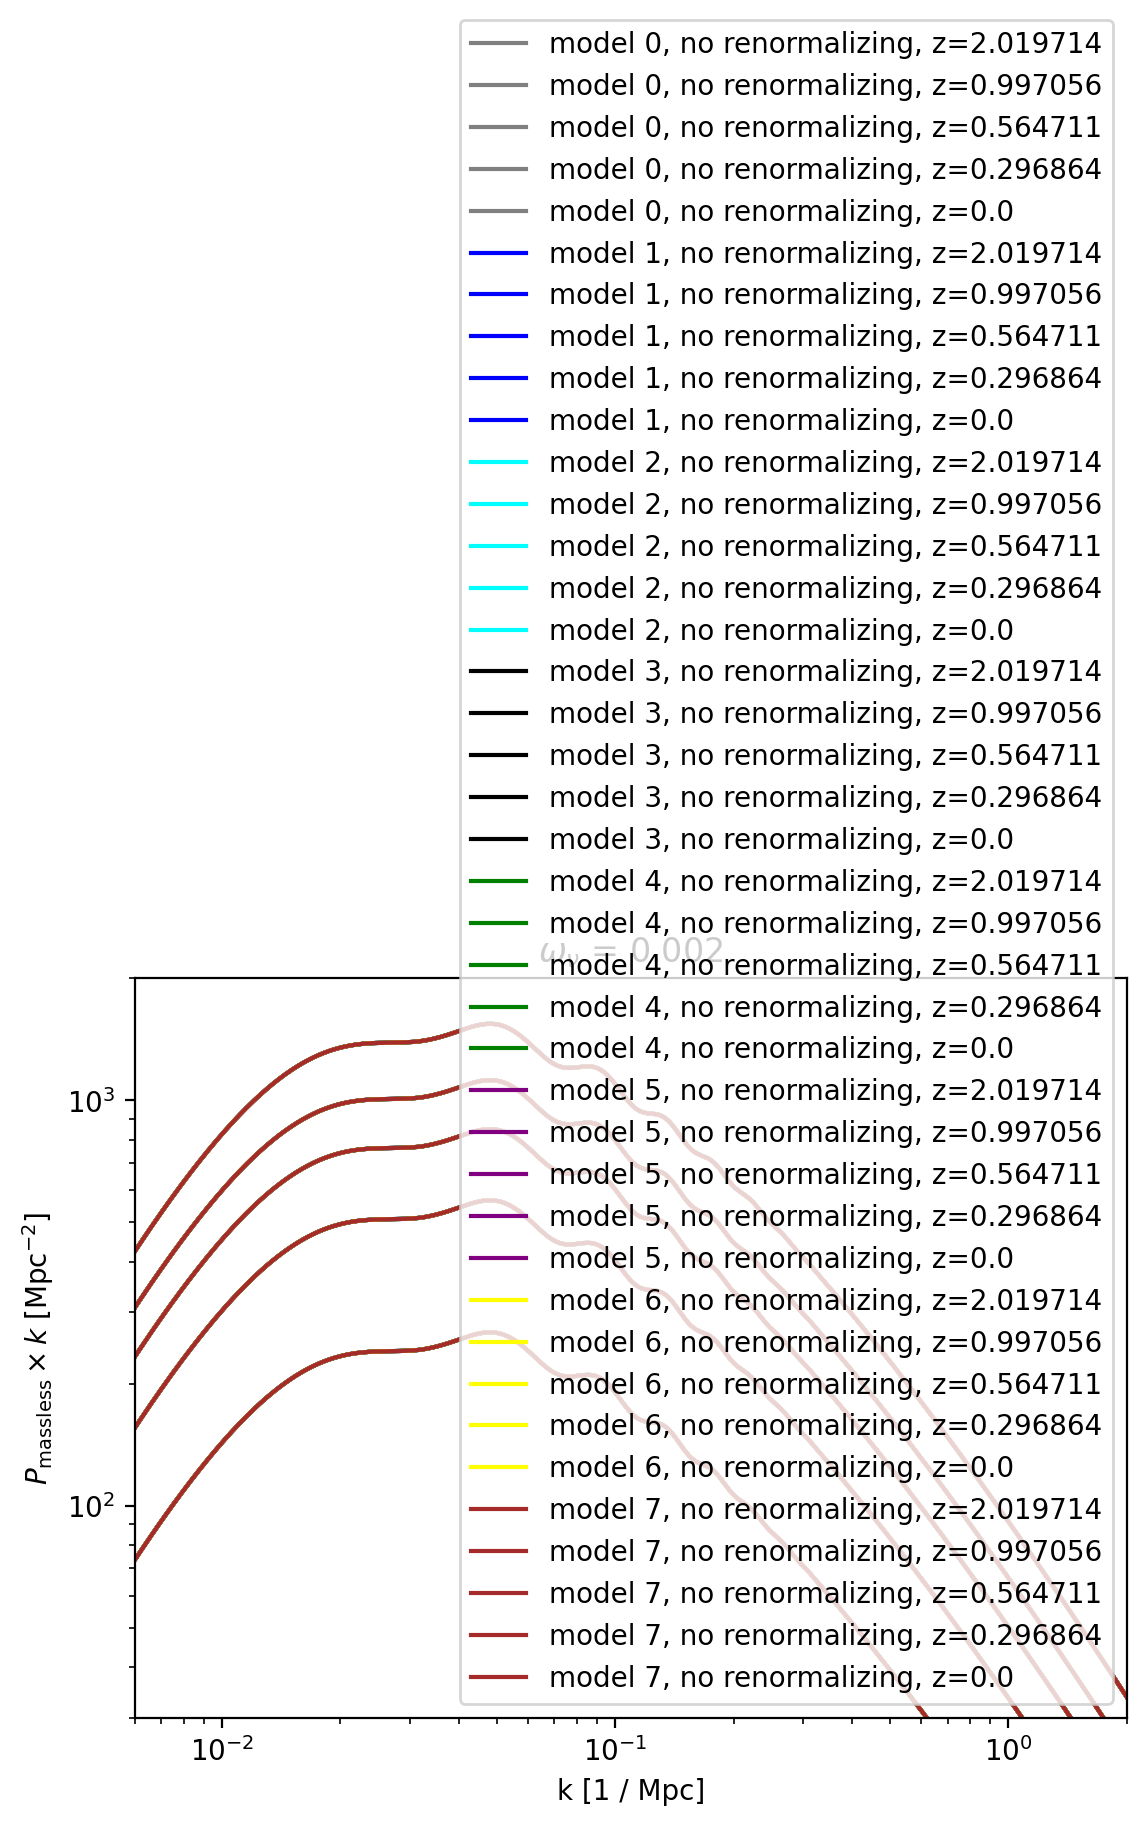

In [10]:
for i in range(len(k_massless_list)):
    h = cosm.loc[i]["h"]
    for j in range(5):
        k = k_massless_list[i] * h
        p = p_massless_list[i][j] / h ** 3
        plt.plot(k, p * k,
                 label="model " + str(i) + \
                 ", no renormalizing, z=" + str(parse_redshifts(index)[j]),
                c=colors[i], linestyle=styles[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.xlim((6e-3, 2))
    plt.ylim((3e1, 2e3))
    plt.ylabel(r"$P_\mathrm{massless} \times k$ [Mpc$^{-2}$]")
    plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]))
    plt.legend()

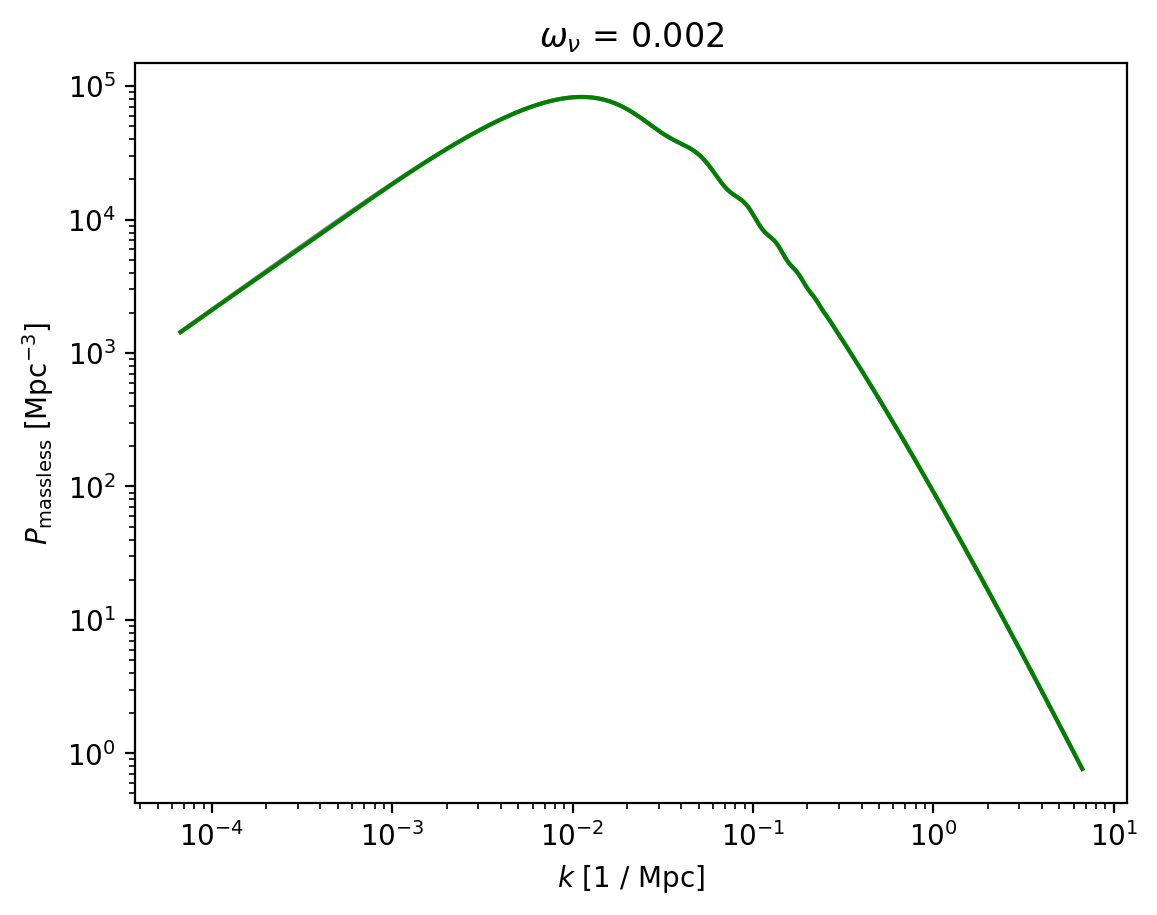

In [11]:
for i in range(len(k_massless_list)):
    if i != 0 and i != 4:
        continue
    h = cosm.loc[i]["h"]
    for j in range(5):
        if j != 0:
            continue
        k = k_massless_list[i] * h
        p = p_massless_list[i][j] / h ** 3
        plt.plot(k, p,
                 label="model " + str(i) + \
                 ", no renormalizing, z=" + str(parse_redshifts(index)[j]),
                c=colors[i], linestyle=styles[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$k$ [1 / Mpc]")
    #plt.xlim((6e-3, 2))
    #plt.ylim((1e2, 2e5))
    plt.ylabel(r"$P_\mathrm{massless}$ [Mpc$^{-3}$]")
    plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]))
    #plt.legend()

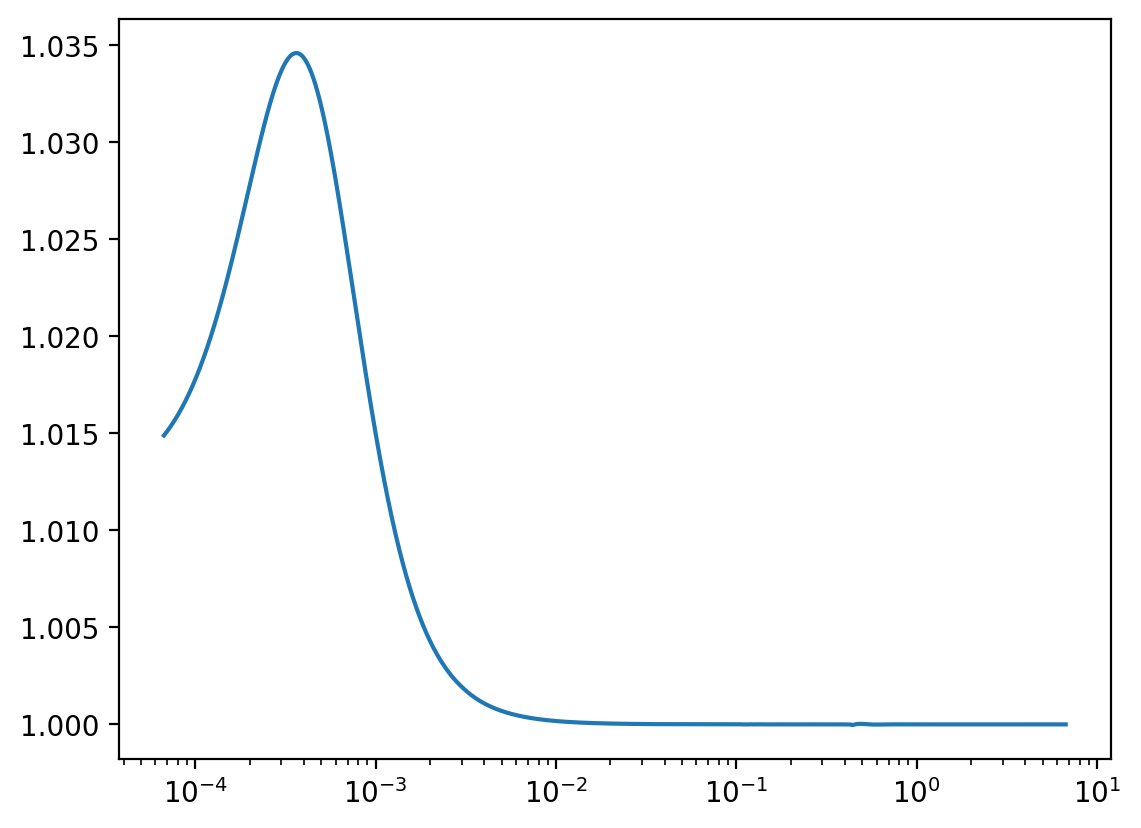

In [12]:
h0 = cosm.loc[0]["h"]
h3 = cosm.loc[3]["h"]
plt.plot(k_massless_list[0] * h0,
    p_massless_list[3][0] / p_massless_list[0][0])
plt.xscale('log')